In [1]:
from model import PModel
from PIL import Image

import numpy as np
from matplotlib import pyplot as plt

### Set global parameters used in all simulations

In [2]:
#Global parameters for Pareto front
n_loci = 9      #Number of loci
p1 = 0.3        #Probability of first-order epistatic interaction
p2 = 0.3        #Probability of second-order epistatic interaction
sigma1 = 0.3    #Standard deviation for first-order epistasis
sigma2 = 0.3    #Standard deviation for second-order epistasis
beta = 0.005    #Baseline transmission rate

#Parameters for evolutionary simulation
n_loci = 9
n_gens = 15
t = (0, 1000)

### The diversity_panel function can be used to run a series of simulations with equal parameters, and record the proportion of polymorphic outcomes, the Shannon diversity index, and the nucleotide diversity

In [3]:
def diversity_panel(n_sims, n_loci=n_loci, epistasis=0, n_gens=n_gens, t=t, beta=beta):
	#Initialize model
	model = PModel(n_loci, np.zeros(n_loci), np.zeros(n_loci), beta=beta)
	
	threshold = 5

	#Counter variables for the number of monomorphic and polymorphic simulations
	n_mono = 0
	n_poly = 0

	n_div = np.zeros(n_sims)
	s_div = np.zeros(n_sims)

	for i in range(n_sims):
		print(i, end='\r')
		#Sample costs and benefits
		cost = np.random.exponential(0.1, n_loci)
		res = np.random.exponential(0.1, n_loci)

		#Update model parameters and add epistasis
		model.update_loci(res, cost)
		if epistasis == 1:
			model.add_epistasis(2, p1, sigma1)
		elif epistasis == 2:
			model.add_epistasis(2, p1, sigma1)
			model.add_epistasis(3, p2, sigma2)

		model.normalize()

		#Run dynamical simulation
		X_t, _ = model.run_sim(t, n_gens)

		#Check for polymorphism and update counters
		if np.sum(X_t[:, -1] > threshold) > 1:
			n_poly += 1
		else:
			n_mono += 1

		#Compute nucleotide diversity
		div = 0
		sum = np.sum(X_t[:, -1])

		for j in range(0, model.S_genotypes):
			for k in range(j + 1, model.S_genotypes):
				pi = np.sum(np.absolute(model.G[j] - model.G[k]))
				div += (X_t[j, -1]*X_t[k, -1]*pi) / sum**2

		n_div[i] = div*(sum / (sum + 1))

		#$Compute shannon diversity
		eq_prop = X_t[:,-1] / np.sum(X_t[:,-1])
		eq_prop = eq_prop[eq_prop > 0]
		s_div[i] = -np.sum(eq_prop*np.log(eq_prop))

	return n_div, s_div, n_poly/(n_poly+n_mono)

### The following code runs three different sets of simulations, with different levels of epistasis

In [4]:
from multiprocessing import Pool

def assign_func(epi_level):
    return diversity_panel(500, epistasis=epi_level, n_loci=9)

if __name__ == '__main__':
    with Pool(5) as p:
        results = p.map(assign_func, [0, 1, 2])

n_div_0, s_div_0, prop_0 = results[0]
n_div_1, s_div_1, prop_1 = results[1]
n_div_2, s_div_2, prop_2 = results[2]

In [5]:
#Print the results of the simulation arrays
print('Polymorphism Frequency:')
print(prop_0, prop_1, prop_2)

print('Nucleotide Diversity:')
print('means:', np.mean(n_div_0), np.mean(n_div_1), np.mean(n_div_2))
print('standard deviations:', np.std(n_div_0), np.std(n_div_1), np.std(n_div_2))

print('Shannon Diversity:')
print('means:', np.mean(s_div_0), np.mean(s_div_1), np.mean(s_div_2))
print('standard deviations:', np.std(s_div_0), np.std(s_div_1), np.std(s_div_2))


Polymorphism Frequency:
0.274 0.37 0.41
Nucleotide Diversity:
means: 0.04756178715686211 0.08743530193868979 0.15319459490390222
standard deviations: 0.08564290304344338 0.14674861902526193 0.2593431140121507
Shannon Diversity:
means: 0.14462192451110198 0.1970919144163638 0.21070873948831917
standard deviations: 0.25062260796080565 0.2721194224971361 0.2781539875366755


### The code here runs a single model instatiation of the model and produces an adaptive dynamics like raster figure

In [84]:
#Sample costs and benefits
cost = np.random.exponential(0.1, n_loci)
res = np.random.exponential(0.1, n_loci)

#Initialize model
model = PModel(n_loci, res, cost, beta=beta)
model.normalize()

#Run dynamical simulation
X_t, I_t = model.run_sim(t, n_gens)

#Resample results into time and genotype bins to create a raster
n_res_bins = 15
n_time_bins = 15

evol_plot = np.zeros((n_res_bins, n_time_bins))
res_bins = np.linspace(0, model.beta, n_res_bins)
time_bins = np.linspace(0, n_gens, n_time_bins)
time_vals = np.arange(0, n_gens)

for i in range(n_res_bins - 1):
    for j in range(n_time_bins - 1):
        evol_inds = np.logical_and(res_bins[i] < model.B, model.B <= res_bins[i+1])
        time_inds = np.logical_and(time_bins[j] < time_vals, time_vals <= time_bins[j+1])

        filter = np.outer(evol_inds, time_inds)

        if np.any(filter):
            evol_plot[i,j] = np.average(X_t[filter])

t_ticks = np.linspace(0, 1, 7)*n_time_bins
t_tick_labels = np.linspace(0, n_gens, 7, dtype=np.uint)

r_ticks = np.linspace(0, 1, 5)*n_res_bins
r_tick_labels = np.linspace(1, 0, 5)

### The following code generates the graphics for Figure 3

Text(-0.2, 1.1, 'C')

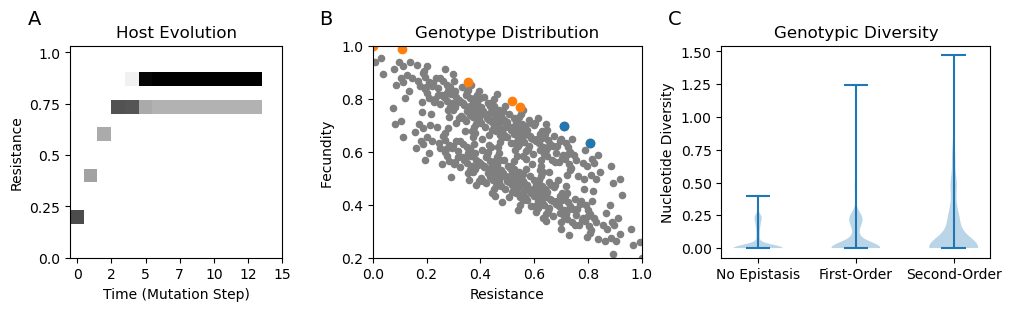

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3), layout='constrained')

genotypes = ax[0].imshow(np.log(1+evol_plot), cmap='Greys')
ax[0].set_title('Host Evolution')
ax[0].set_ylabel('Resistance')
ax[0].set_xlabel('Time (Mutation Step)')
ax[0].set_xticks(t_ticks)
ax[0].set_yticks(r_ticks)
ax[0].set_xticklabels(t_tick_labels)
ax[0].set_yticklabels(r_tick_labels)

abundances = np.max(X_t, axis=1)
ax[1].set_title('Genotype Distribution')
ax[1].set_xlabel('Resistance')
ax[1].set_ylabel('Fecundity ')
ax[1].scatter((1-(model.B/model.beta))[abundances<=1], model.F[abundances<=1], c='tab:gray', s=20)
ax[1].scatter((1-(model.B/model.beta))[abundances>1], model.F[abundances>1], c='tab:orange')
ax[1].scatter((1-(model.B/model.beta))[X_t[:,-1]>1], model.F[X_t[:,-1]>1], c='tab:blue')

ax[2].set_title('Genotypic Diversity')
ax[2].violinplot((n_div_0, n_div_1, n_div_2))
ax[2].set_xticks([1,2,3], ['No Epistasis', 'First-Order', 'Second-Order'])
ax[2].set_ylabel('Nucleotide Diversity')

ax[1].set_xbound(0, 1)
ax[1].set_ybound(0.2, 1)

ax[0].annotate("A", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[1].annotate("B", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[2].annotate("C", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)